# HW 10 CLUSTERING BUSINESS
cluster time trends in NYC businesses: 

## DATA: Census Business data:

## Download census data for businesses by ZIP code. The data is here http://www.census.gov/econ/cbp/download/

## and it can be downloaded by hand. you can also download it with 3 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)



# NYC zip codes shape file is here
## http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981


NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

# 1. Collecting data

In [ ]:
%%bash
cd data 

for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

for ((y=0; y<=1; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; done

for ((y=2; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done


### Get the zip file list of nyc department

In [2]:
import json
import urllib2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
url = "https://nycdatastables.s3.amazonaws.com/2013-08-19T18:18:28.877Z/nyc-zip-code-tabulation-areas-polygons.geojson"
request = urllib2.urlopen(url)
nyc = json.load(request)

In [3]:
# store the nyc_zip
nyc_zip = []
for department in nyc['features']:
    nyc_zip.append(str(department['properties']["postalCode"]))

In [4]:
import os
path = os.getcwd()+'/data'
path
os.chdir(path)

In [5]:
import zipfile #i am not giving it a name cause i intend to use it only once
tr0 = range(1994,2014)
tr1 = range(1998,2003)
ffname = "zbp{0}totals.zip"
biz_zip = set()
for i in tr0:
    if i in tr1:
        st = str(i)[2:]
        fname = ffname.format(st)
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip','.txt')),dtype={'ZIP':str})
        df.columns=[u'zip', u'name', u'empflag', u'emp', u'qp1', u'ap', u'est']
    else:
        st = str(i)[2:]
        fname = ffname.format(st)
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip','.txt')),dtype={'zip':str})
    new_zip = set(df.zip).intersection(set(nyc_zip))
    biz_zip = biz_zip.union(new_zip)

In [6]:
biz_zip = sorted(biz_zip)

In [7]:
biz_data_est = pd.DataFrame(np.nan,index=biz_zip,columns=tr0)

In [8]:
for i in tr0:
    if i in tr1:
        st = str(i)[2:]
        fname = ffname.format(st)
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip','.txt')),dtype={'ZIP':str})
        df.columns=[u'zip', u'name', u'empflag', u'emp', u'qp1', u'ap', u'est']
    else:
        st = str(i)[2:]
        fname = ffname.format(st)
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip','.txt')),dtype={'zip':str})
    for j in biz_zip:
        if j in list(set(df.zip)):
            biz = df[df.zip==j]
            biz_data_est.loc[j][i]=int(biz.est)

In [9]:
biz_data_est = biz_data_est.dropna()

In [10]:
biz_zip = biz_data_est.index

In [11]:
biz_data_est.to_csv('output.csv',index_label='zip')

In [12]:
kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

# 2. Data processing

In [13]:
mydata = pd.read_csv('output.csv',index_col='zip')

In [14]:
result = mydata.copy()
for i in range(len(mydata)):
    result.iloc[i] = (result.iloc[i]-np.mean(result.iloc[i]))/np.std(result.iloc[i])

# 3. KMeans Clustering

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

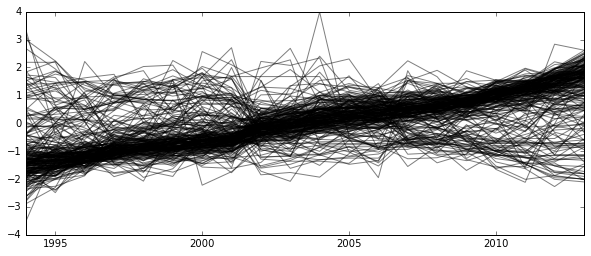

In [16]:
plt.figure(figsize=(10,4))
plt.xlim(1994,2013)
for i in range(len(result)):
    plt.plot(result.iloc[i],'k',alpha=0.5)

In [17]:
def euclid_dist(t1,t2):
    return np.sqrt(sum((t1-t2)**2))

In [18]:
import random
def k_means_clust(data,num_clust,num_iter):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        print counter
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if euclid_dist(i,j)<min_dist:
                    min_dist = euclid_dist(i,j)
                    closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
    
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    return centroids

In [19]:
x = result.values
centroids=k_means_clust(x,2,10)
assignments={}
#assign data points to clusters
for ind,i in enumerate(x):
    min_dist=float('inf')
    closest_clust=None
    for c_ind,j in enumerate(centroids):
        if euclid_dist(i,j)<min_dist:
            min_dist = euclid_dist(i,j)
            closest_clust=c_ind
    if closest_clust in assignments:
        assignments[closest_clust].append(ind)
    else:
        assignments[closest_clust]=[ind]

1
2
3
4
5
6
7
8
9
10


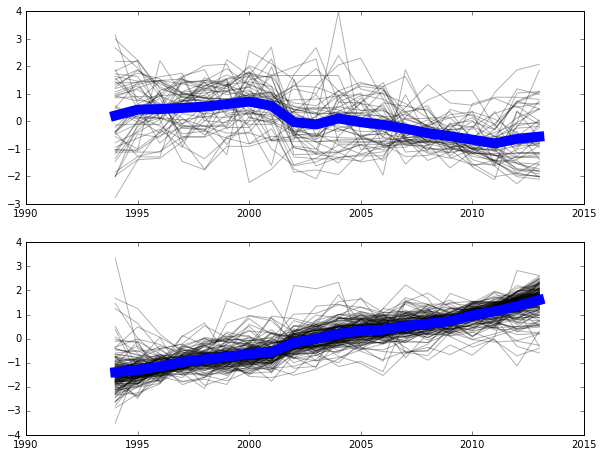

In [20]:
cluster = pd.Series(0)
for i,key in assignments.iteritems():
    for j in key:
        cluster[j] = i
cluster = cluster.sort_index()
mydata = pd.DataFrame({'zips':biz_zip,
                       'cluster':cluster})
zips = str(mydata.iloc[i]['zips'])
cluster = mydata.iloc[i]['cluster']

fig = plt.figure(figsize=(10,20))
ax = []
for i in range(len(centroids)):
    ax.append(fig.add_subplot(5,1,i+1)) 
for i in range(len(mydata)):
    cluster = mydata.iloc[i]['cluster']
    ax[cluster].plot(result.iloc[i],'k',alpha=0.3)
for i in range(len(centroids)):    
    ax[i].plot(tr0,centroids[i],linewidth=10)

In [21]:
centroids=k_means_clust(x,3,10)
assignments={}
#assign data points to clusters
for ind,i in enumerate(x):
    min_dist=float('inf')
    closest_clust=None
    for c_ind,j in enumerate(centroids):
        if euclid_dist(i,j)<min_dist:
            min_dist = euclid_dist(i,j)
            closest_clust=c_ind
    if closest_clust in assignments:
        assignments[closest_clust].append(ind)
    else:
        assignments[closest_clust]=[ind]

1
2
3
4
5
6
7
8
9
10


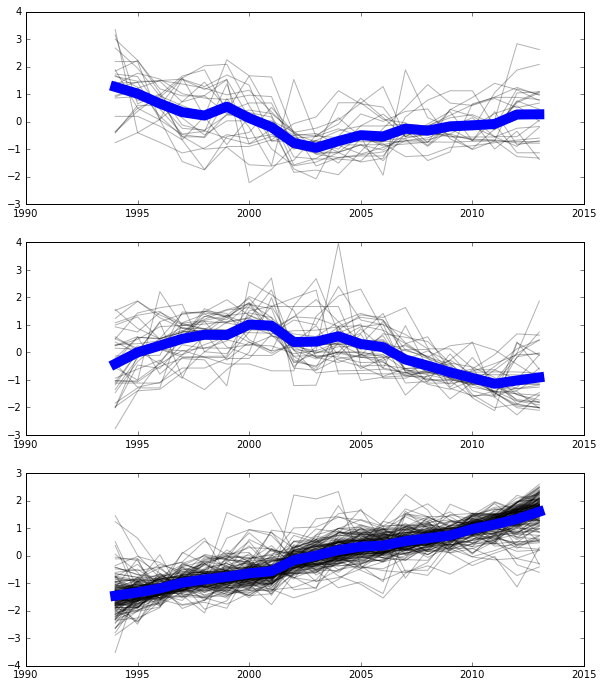

In [22]:
cluster = pd.Series(0)
for i,key in assignments.iteritems():
    for j in key:
        cluster[j] = i
cluster = cluster.sort_index()
mydata = pd.DataFrame({'zips':biz_zip,
                       'cluster':cluster})
zips = str(mydata.iloc[i]['zips'])
cluster = mydata.iloc[i]['cluster']

fig = plt.figure(figsize=(10,20))
ax = []
for i in range(len(centroids)):
    ax.append(fig.add_subplot(5,1,i+1)) 
for i in range(len(mydata)):
    cluster = mydata.iloc[i]['cluster']
    ax[cluster].plot(result.iloc[i],'k',alpha=0.3)
for i in range(len(centroids)):    
    ax[i].plot(tr0,centroids[i],linewidth=10)

In [23]:
centroids=k_means_clust(x,4,10)
assignments={}
#assign data points to clusters
for ind,i in enumerate(x):
    min_dist=float('inf')
    closest_clust=None
    for c_ind,j in enumerate(centroids):
        if euclid_dist(i,j)<min_dist:
            min_dist = euclid_dist(i,j)
            closest_clust=c_ind
    if closest_clust in assignments:
        assignments[closest_clust].append(ind)
    else:
        assignments[closest_clust]=[ind]

1
2
3
4
5
6
7
8
9
10


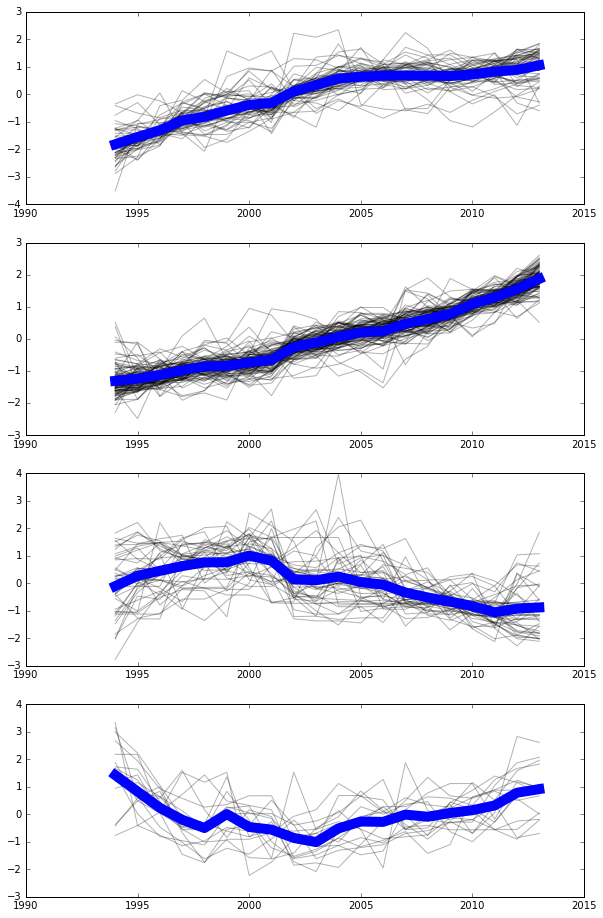

In [24]:
cluster = pd.Series(0)
for i,key in assignments.iteritems():
    for j in key:
        cluster[j] = i
cluster = cluster.sort_index()
mydata = pd.DataFrame({'zips':biz_zip,
                       'cluster':cluster})
zips = str(mydata.iloc[i]['zips'])
cluster = mydata.iloc[i]['cluster']

fig = plt.figure(figsize=(10,20))
ax = []
for i in range(len(centroids)):
    ax.append(fig.add_subplot(5,1,i+1)) 
for i in range(len(mydata)):
    cluster = mydata.iloc[i]['cluster']
    ax[cluster].plot(result.iloc[i],'k',alpha=0.3)
for i in range(len(centroids)):    
    ax[i].plot(tr0,centroids[i],linewidth=10)

In [25]:
centroids=k_means_clust(x,5,10)
assignments={}
#assign data points to clusters
for ind,i in enumerate(x):
    min_dist=float('inf')
    closest_clust=None
    for c_ind,j in enumerate(centroids):
        if euclid_dist(i,j)<min_dist:
            min_dist = euclid_dist(i,j)
            closest_clust=c_ind
    if closest_clust in assignments:
        assignments[closest_clust].append(ind)
    else:
        assignments[closest_clust]=[ind]

1
2
3
4
5
6
7
8
9
10


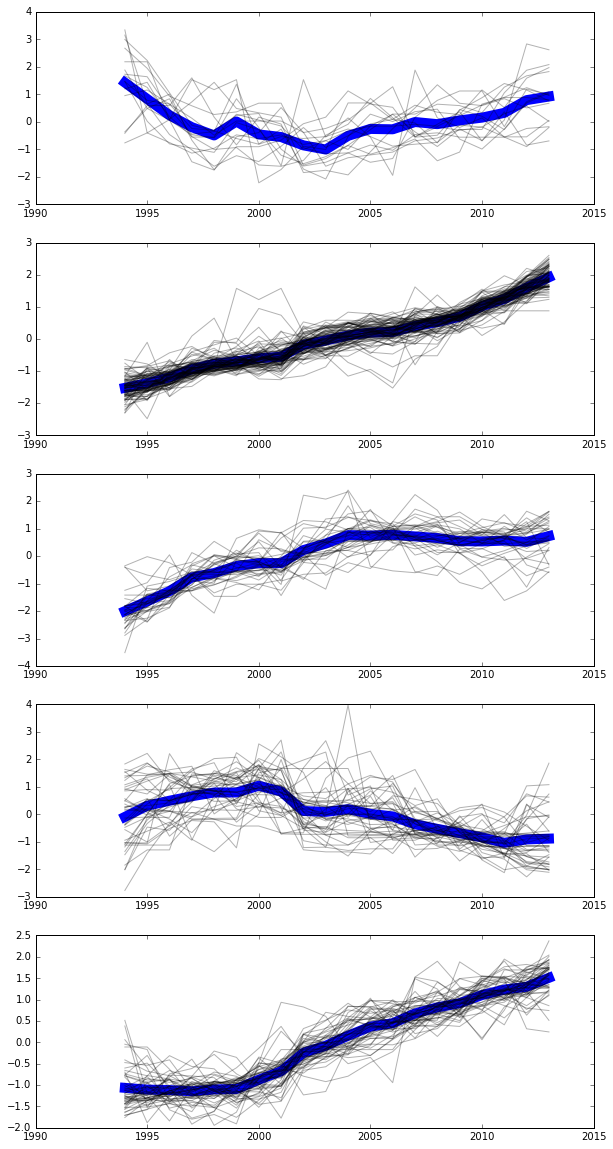

In [26]:
cluster = pd.Series(0)
for i,key in assignments.iteritems():
    for j in key:
        cluster[j] = i
cluster = cluster.sort_index()
mydata = pd.DataFrame({'zips':biz_zip,
                       'cluster':cluster})
zips = str(mydata.iloc[i]['zips'])
cluster = mydata.iloc[i]['cluster']

fig = plt.figure(figsize=(10,20))
ax = []
for i in range(len(centroids)):
    ax.append(fig.add_subplot(5,1,i+1))
    ax[i].plot(tr0,centroids[i],linewidth=10) 
for i in range(len(mydata)):
    cluster = mydata.iloc[i]['cluster']
    ax[cluster].plot(result.iloc[i],'k',alpha=0.3)

# 4. DBScan Cluster

In [27]:
# Calculate distance matrix
dist_mat = pd.DataFrame(np.zeros(shape=(len(result),len(result))))
for i in range(len(result)):
    for j in range(len(result)):
        dist_mat.iloc[i][j] = euclid_dist(result.iloc[i],result.iloc[j])

In [28]:
from sklearn.cluster import DBSCAN
db = DBSCAN(metric="precomputed",eps=2).fit(dist_mat)

In [29]:
labels = (db.labels_).astype(int)
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
#clusters = pd.Series([coordinates[labels == i] for i in xrange(num_clusters)])
print('Number of clusters: %d' % num_clusters)

Number of clusters: 3


In [30]:
len(biz_zip)

230

In [31]:
cluster = db.labels_+2
mydata3 = pd.DataFrame({'zips':biz_zip,
                       'cluster':cluster})

# 5. Plotting

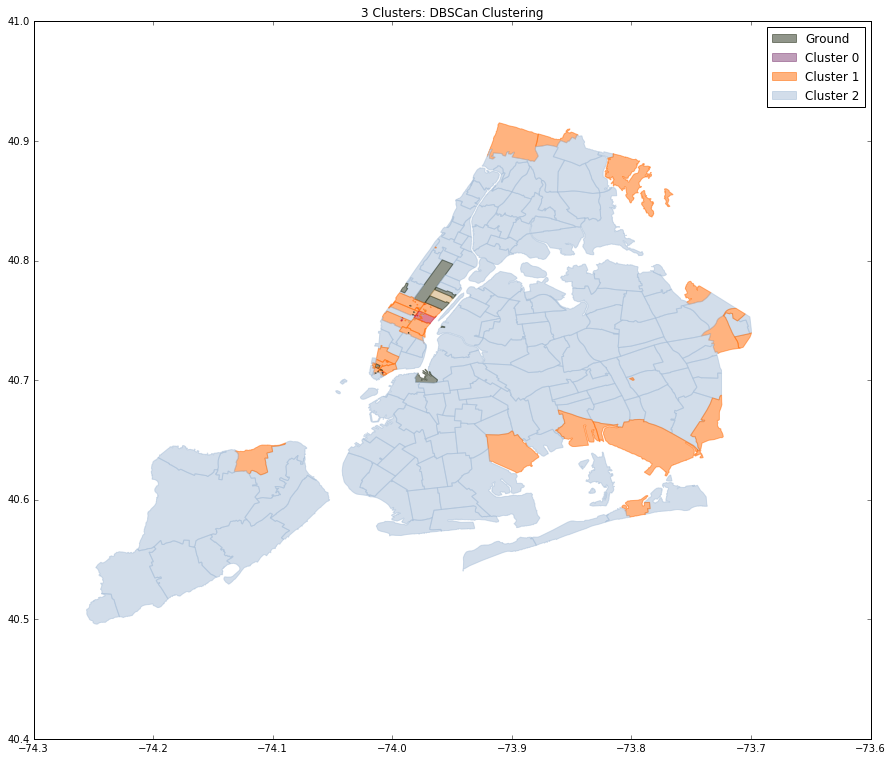

In [32]:
import matplotlib.pyplot as plt 
from descartes import PolygonPatch
fig = plt.figure(figsize=(15,15)) 
for i in nyc['features']:
    poly = i['geometry']
    postcode = str(i['properties']['postalCode'])
    ax = fig.gca()
    GREEN = kelly_colors_hex[19]
    if postcode in list(set(biz_zip)):
        color = kelly_colors_hex[int(mydata3[mydata3['zips']==postcode]['cluster'])+1]
        ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5, zorder=2 ))
    else:
        ax.add_patch(PolygonPatch(poly, fc=GREEN, ec=GREEN, alpha=0.5, zorder=2 ))
ax.axis('scaled')
import matplotlib.patches as mpatches

ground = mpatches.Patch(color=GREEN, alpha=0.5, label='Ground')
patch0 = mpatches.Patch(color=kelly_colors_hex[1], alpha=0.5, label='Cluster 0')
patch1 = mpatches.Patch(color=kelly_colors_hex[2], alpha=0.5, label='Cluster 1')
patch2 = mpatches.Patch(color=kelly_colors_hex[3], alpha=0.5, label='Cluster 2')
plt.legend(handles=[ground,patch0,patch1,patch2],loc='best')
plt.title('3 Clusters: DBSCan Clustering')

In [33]:
centroids=k_means_clust(x,3,10)
assignments={}
#assign data points to clusters
for ind,i in enumerate(x):
    min_dist=float('inf')
    closest_clust=None
    for c_ind,j in enumerate(centroids):
        if euclid_dist(i,j)<min_dist:
            min_dist = euclid_dist(i,j)
            closest_clust=c_ind
    if closest_clust in assignments:
        assignments[closest_clust].append(ind)
    else:
        assignments[closest_clust]=[ind]

zips = pd.Series(result.index,dtype=str)
cluster = pd.Series(0)
for i,key in assignments.iteritems():
    for j in key:
        cluster[j] = i
cluster = cluster.sort_index()
mydata2 = pd.DataFrame({'zips':biz_zip,
                       'cluster':cluster})

1
2
3
4
5
6
7
8
9
10


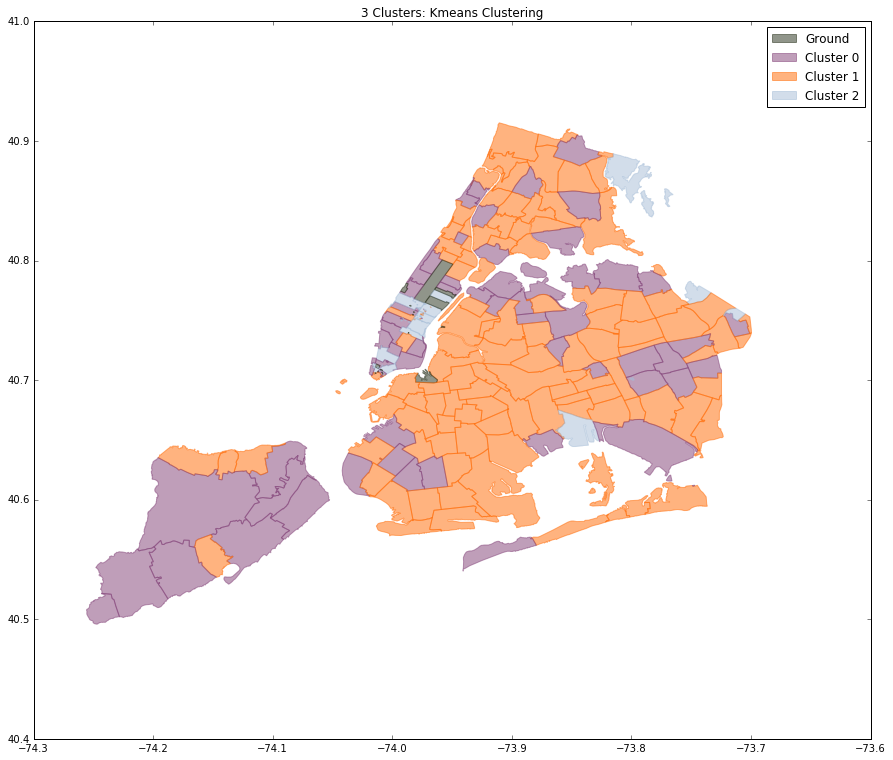

In [34]:
import matplotlib.pyplot as plt 
from descartes import PolygonPatch
fig = plt.figure(figsize=(15,15)) 
for i in nyc['features']:
    poly = i['geometry']
    postcode = str(i['properties']['postalCode'])
    ax = fig.gca()
    GREEN = kelly_colors_hex[19]
    if postcode in list(set(biz_zip)):
        color = kelly_colors_hex[int(mydata2[mydata2['zips']==postcode]['cluster'])+1]
        ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5, zorder=2 ))
    else:
        ax.add_patch(PolygonPatch(poly, fc=GREEN, ec=GREEN, alpha=0.5, zorder=2 ))
ax.axis('scaled')
import matplotlib.patches as mpatches

ground = mpatches.Patch(color=GREEN, alpha=0.5, label='Ground')
patch0 = mpatches.Patch(color=kelly_colors_hex[1], alpha=0.5, label='Cluster 0')
patch1 = mpatches.Patch(color=kelly_colors_hex[2], alpha=0.5, label='Cluster 1')
patch2 = mpatches.Patch(color=kelly_colors_hex[3], alpha=0.5, label='Cluster 2')
plt.legend(handles=[ground,patch0,patch1,patch2],loc='best')
plt.title('3 Clusters: Kmeans Clustering')

# 6. Model Comparison 

It's hard to say which model is better. But as we can see, it's in more detail in the K-means clustering. 